## Community Analysis

This notebook will summarize important attributes of a community from given building inventory and housing unit allocation information. This helps in understanding the data of the community avaiable on IN-CORE

In [1]:
## Importing all the modules from incore

import os
import pandas as pd
import geopandas as gpd
import contextily as ctx
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=12,10

from pyincore import IncoreClient, Dataset, FragilityService, MappingSet, DataService
from pyincore.analyses.buildingdamage import BuildingDamage
from pyincore.analyses.cumulativebuildingdamage import CumulativeBuildingDamage
from pyincore.analyses.populationdislocation import PopulationDislocation, PopulationDislocationUtil
from pyincore.analyses.housingunitallocation import HousingUnitAllocation

from pyincore_viz.geoutil import GeoUtil as viz
import warnings
warnings.filterwarnings('ignore')

In [2]:
client = IncoreClient()
data_service = DataService(client)

Connection successful to IN-CORE services. pyIncore version detected: 0.9.0


### INPUT DATA

The building inventory information should be given in .csv format 
The housing unit allocatoin information given in .csv format

In [28]:
#Input data
bInv = pd.read_csv("Seaside_Building_Inventory_xy.csv") #Building Inventory Data
hua = pd.read_csv("IN-CORE_1cv1_housingunitallocation_1238.csv") #Housing Unit Allocation Data (The ouput file oh housing unit analysis)

#### Option to remove outlier

In [29]:
outlier = int(input("1 for no outlier, 0 for outlier"))

1 for no outlier, 0 for outlier1


In [31]:
if outlier==1:
    #Run this cell only if you want to remove outliers
    old_len = len(bInv)
    bInv = bInv[(bInv.appr_bldg>10000) & (bInv.appr_bldg<1e6)]
    bInv = bInv[(bInv.year_built>1900) & (bInv.year_built<2011)]
    print("Rows dropped: {}".format(old_len - len(bInv)))

Rows dropped: 378


###### Converting the data frame to gdf

In [32]:
# Use shapely.wkt loads to convert WKT to GeoSeries
from shapely.geometry import Point
# Geodata frame requires geometry and CRS to be set
hua_gdf = gpd.GeoDataFrame(
    hua,
    crs={'init': 'epsg:4326'},
    geometry=[Point(xy) for xy in zip(hua['x'], hua['y'])])
hua_gdf[['guid','x','y','numprec','geometry']].head(6)

,guid,x,y,numprec,geometry
0,e38d8575-7880-4a8c-b6d7-225ab1cf9264,-123.896065,46.012722,2.0,POINT (-123.89606 46.01272)
1,af5771b4-4f42-4166-b772-78a3706fa8ac,-123.903427,46.017498,1.0,POINT (-123.90343 46.01750)
2,37532fb5-5107-478b-ab2c-158eb001c68b,-123.903427,46.017498,4.0,POINT (-123.90343 46.01750)
3,66d39314-1c68-4634-a82c-8fcb37f529ff,-123.900246,46.013523,3.0,POINT (-123.90025 46.01352)
4,e519ec32-c5eb-422a-be3d-7ff4bb33f1e2,-123.898918,46.012257,2.0,POINT (-123.89892 46.01226)
5,0edcff97-8fa1-4558-b80e-610abe7b9f17,-123.898552,46.012253,7.0,POINT (-123.89855 46.01225)


In [33]:
# Use shapely.wkt loads to convert WKT to GeoSeries
from shapely.geometry import Point
# Geodata frame requires geometry and CRS to be set
bldg_inv_gdf = gpd.GeoDataFrame(
    bInv,
    crs={'init': 'epsg:4326'},
    geometry=[Point(xy) for xy in zip(bInv['x'], bInv['y'])])
bldg_inv_gdf[['guid','x','y','year_built','geometry']].head(6)

,guid,x,y,year_built,geometry
1,65d6e370-c05b-4b2f-bd17-d914d1d056c7,-123.905846,45.997948,1992,POINT (-123.90585 45.99795)
5,9020fc6c-4b0e-4e5b-b8be-fa58141b57b5,-123.905846,45.997948,2007,POINT (-123.90585 45.99795)
10,0b4073d3-7d7e-439d-b9ef-1373291f37cc,-123.905846,45.997948,1992,POINT (-123.90585 45.99795)
11,bef20397-d546-475e-8dfd-b58a422019d8,-123.903778,46.003887,2006,POINT (-123.90378 46.00389)
12,f5e2c264-da77-4971-99d8-0c3d7562b986,-123.915581,45.996147,1988,POINT (-123.91558 45.99615)
13,d8ffb229-86e0-4907-97a5-84eb9ac248e6,NaN,NaN,1959,POINT (nan nan)


In [34]:
bInv.columns
#important ones are appr_bldg, struct_typ, year_built
#should have unique guid 

Index(['Unnamed: 0', 'parid', 'parid_card', 'bldg_id', 'struct_typ',
       'str_prob', 'year_built', 'no_stories', 'a_stories', 'b_stories',
       'bsmt_type', 'sq_foot', 'gsq_foot', 'occ_type', 'occ_detail',
       'major_occ', 'broad_occ', 'appr_bldg', 'repl_cst', 'str_cst',
       'nstra_cst', 'nstrd_cst', 'dgn_lvl', 'cont_val', 'efacility',
       'dwell_unit', 'str_typ2', 'occ_typ2', 'tract_id', 'guid', 'FID_NEW',
       'origin', 'stat_class', 'rmv_improv', 'rmv_land', 'elev', 'period',
       'strctid', 'x', 'y', 'value_matc', 'geometry'],
      dtype='object')

In [35]:
hua.columns
#important ones are race, hispan, gqtype

Index(['Unnamed: 0', 'addrptid', 'parid', 'parid_card', 'bldg_id',
       'struct_typ', 'str_prob', 'year_built', 'no_stories', 'a_stories',
       'b_stories', 'bsmt_type', 'sq_foot', 'gsq_foot', 'occ_type',
       'occ_detail', 'major_occ', 'broad_occ', 'appr_bldg', 'repl_cst',
       'str_cst', 'nstra_cst', 'nstrd_cst', 'dgn_lvl', 'cont_val', 'efacility',
       'dwell_unit', 'str_typ2', 'occ_typ2', 'tract_id', 'guid', 'FID_NEW',
       'origin', 'stat_class', 'rmv_improv', 'rmv_land', 'elev', 'period',
       'strctid', 'value_matc', 'blockid', 'huestimate', 'residential', 'x',
       'y', 'randomap', 'randommergeorder', 'blockidstr', 'huid', 'livetype',
       'numprec', 'ownershp', 'race', 'hispan', 'vacancy', 'gqtype', 'bgid',
       'randomhu', 'aphumerge', 'geometry', 'Race Ethnicity', 'Tenure Status'],
      dtype='object')

### Archtype

In [36]:
#present this table nicely - pivot table - Nathanael's notebook
bInv.struct_typ.value_counts()

W1    2279
RC    1341
W2     681
Name: struct_typ, dtype: int64

Text(0.5, 1.0, 'Structure Type Distribution')

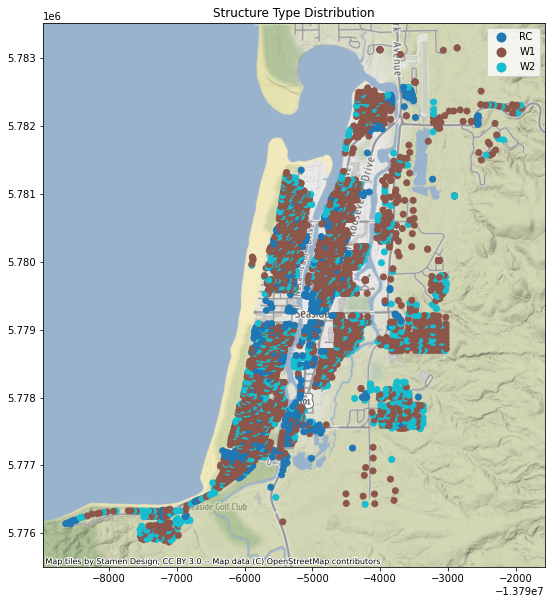

In [64]:
strct_typ_map = viz.plot_gdf_map(bldg_inv_gdf,column='struct_typ')
plt.title("Structure Type Distribution")

### Appraisal Value

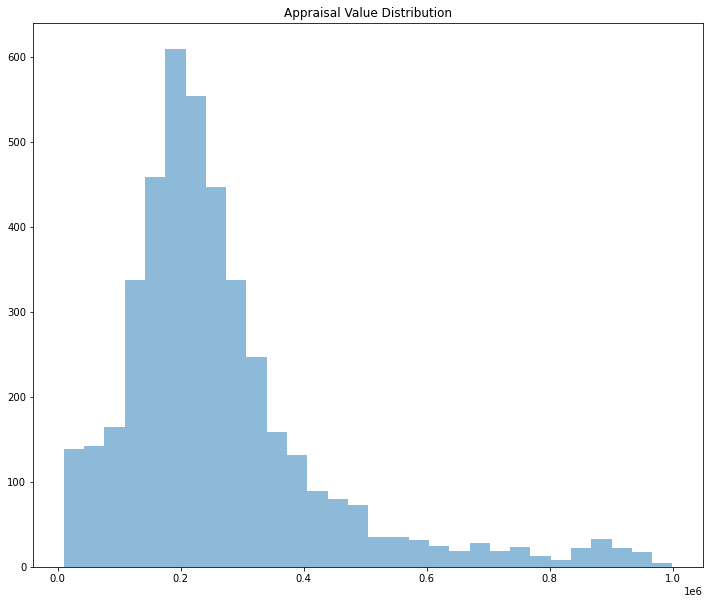

In [63]:
if outlier==1:
    bInv.appr_bldg.hist(bins=30, alpha = 0.5, grid=False)
    plt.title("Appraisal Value Distribution")
else:
    bInv.appr_bldg.hist(bins=300, alpha = 0.5, grid=False)
    plt.xlim(0, 1e6)
    plt.title("Appraisal Value Distribution")

Text(0.5, 1.0, 'Appraisal Value')

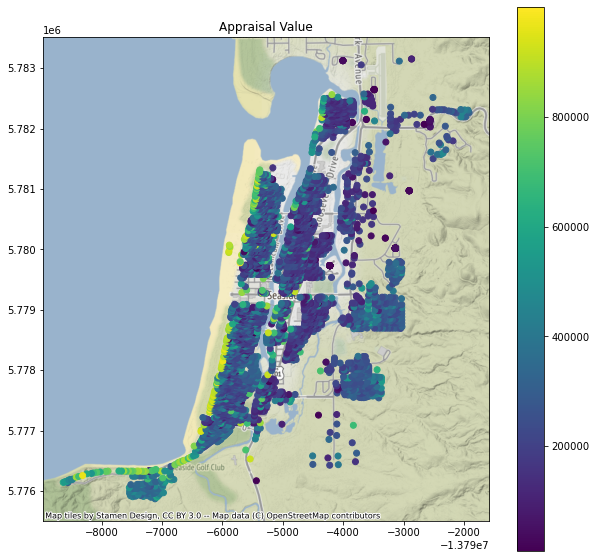

In [62]:
appr_bldg_map = viz.plot_gdf_map(bldg_inv_gdf,column='appr_bldg')
plt.title("Appraisal Value")

### Building Age

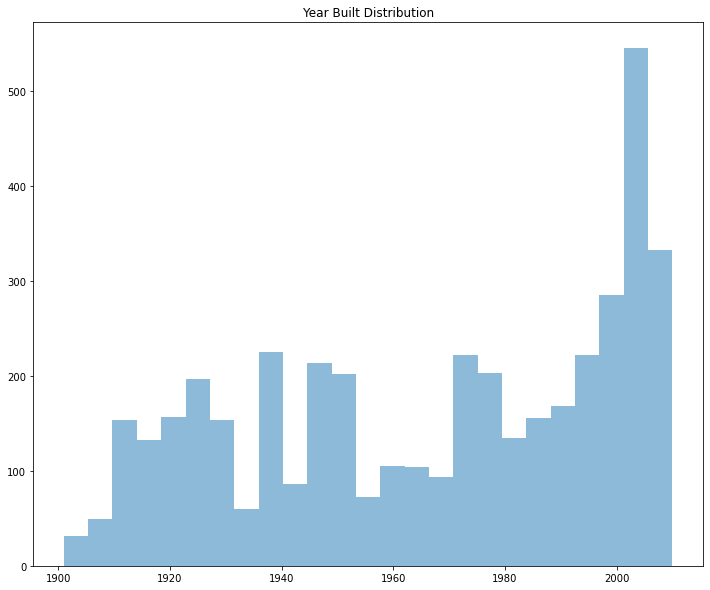

In [60]:
if outlier==1:
    bInv.year_built.hist(bins=25, alpha = 0.5, grid=False)
    plt.title("Year Built Distribution")
else:
    bInv.year_built.hist(bins=300, alpha = 0.5, grid=False)
    plt.xlim(0, 1e6)
    plt.title("Year Built Distribution")

In [41]:
Retrofit = bInv["dgn_lvl"].value_counts()
print("Total Number of Buildings in the community for each Retrofit Level: \n", Retrofit)

Total Number of Buildings in the community for each Retrofit Level: 
 Pre - Code         2283
Moderate - Code     818
Low - Code          696
High - Code         504
Name: dgn_lvl, dtype: int64


Text(0.5, 1.0, 'Distribution of buildings in each design level')

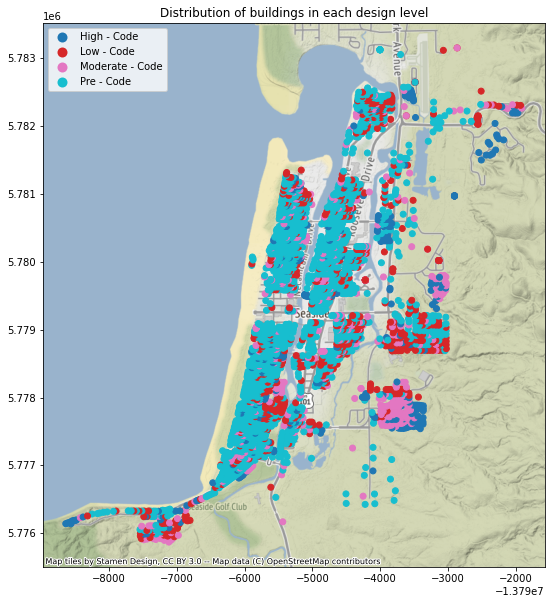

In [58]:
year_built_map = viz.plot_gdf_map(bldg_inv_gdf,column='dgn_lvl')
plt.title("Distribution of buildings in each design level")

### Pivot Table for Year Built

In [ ]:
Himadri

### Race and Ethnicity

In [98]:
hua['Race Ethnicity'] = "0 Vacant HU No Race Ethnicity Data"
hua['Race Ethnicity'].notes = "Identify Race and Ethnicity Housing Unit Characteristics."

hua.loc[(hua['race'] == 1) & (hua['hispan'] == 0),'Race Ethnicity'] = "1 White alone, Not Hispanic"
hua.loc[(hua['race'] == 2) & (hua['hispan'] == 0),'Race Ethnicity'] = "2 Black alone, Not Hispanic"
hua.loc[(hua['race'].isin([3,4,5,6,7])) & (hua['hispan'] == 0),'Race Ethnicity'] = "3 Other Race, Not Hispanic"
hua.loc[(hua['hispan'] == 1),'Race Ethnicity'] = "4 Any Race, Hispanic"
hua.loc[(hua['gqtype'] >= 1),'Race Ethnicity'] = "5 Group Quarters no Race Ethnicity Data"

In [99]:
hua_re  = hua[["Race Ethnicity", "huestimate"]]
hua_re.dropna(inplace=True)

In [106]:
plt.rcParams["figure.figsize"]=12,12

<AxesSubplot:ylabel='huestimate'>

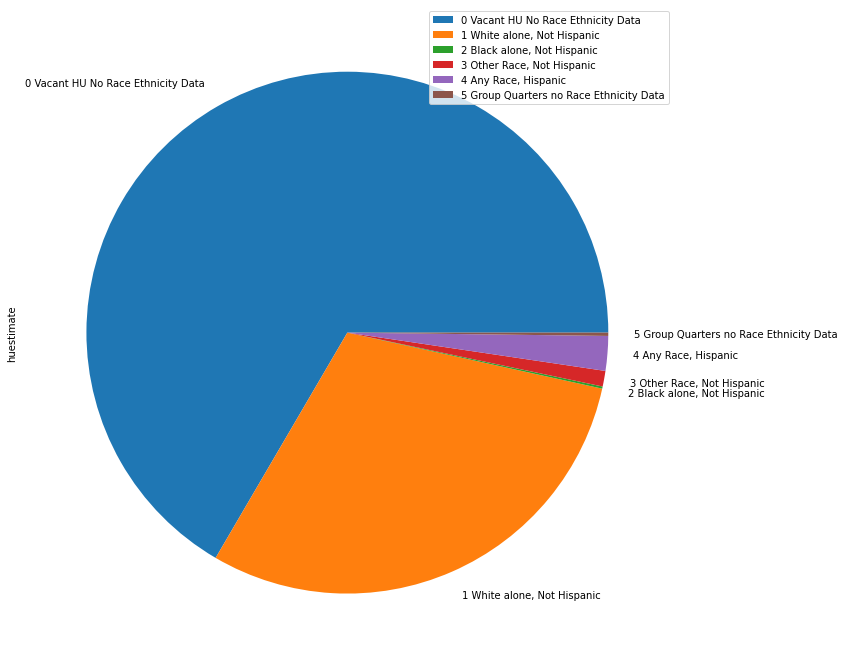

In [107]:
hua.groupby(['Race Ethnicity']).sum().plot(kind='pie', y='huestimate')

### Population Spread in the Community

In [48]:
table = pd.pivot_table(hua, values='numprec', index=['Race Ethnicity'],
                                     margins = True, margins_name = 'Total',
                                     columns=['Tenure Status'], aggfunc=[np.sum]).rename(
    columns={'Total': 'Total Population', 'sum': ''})
table_title = "Table 1. Total Population by Race, Ethncity, and Tenure Status 2010."
varformat = {('','Total Population'): "{:,.0f}",
             ('','0 No Tenure Status'): "{:,.0f}",
             ('','1 Owner Occupied'): "{:,.0f}",
             ('','2 Renter Occupied'): "{:,.0f}"}
table.style.set_caption(table_title).format(varformat)

In [48]:
table = pd.pivot_table(hua, values='new_pop', index=['Race Ethnicity'],
                                     margins = True, margins_name = 'Total',
                                     columns=['Tenure Status'], aggfunc=[np.sum]).rename(
    columns={'Total': 'Total Population', 'sum': ''})
table_title = "Table 1. Total Population by Race, Ethncity, and Tenure Status 2010."
varformat = {('','Total Population'): "{:,.0f}",
             ('','0 No Tenure Status'): "{:,.0f}",
             ('','1 Owner Occupied'): "{:,.0f}",
             ('','2 Renter Occupied'): "{:,.0f}"}
table.style.set_caption(table_title).format(varformat)

Text(0.5, 1.0, 'Tenure Status')

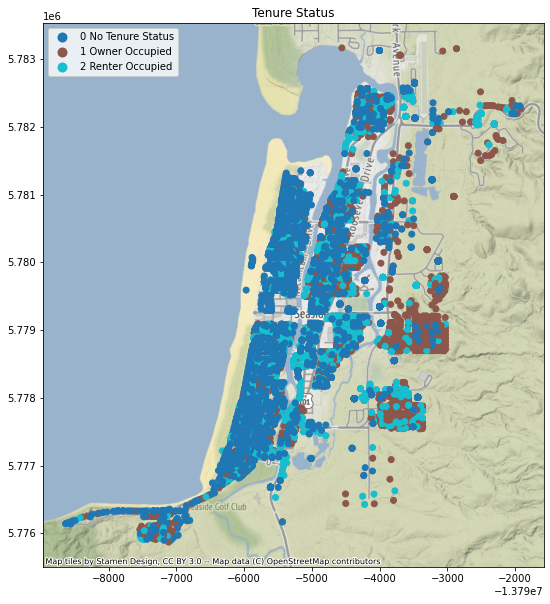

In [81]:
pop_map = viz.plot_gdf_map(hua_gdf,column='Tenure Status')
plt.title("Tenure Status")

In [96]:
#Grouping population
hua_gdf["new_pop"] = hua_gdf.numprec.copy()
hua_gdf.new_pop[hua_gdf.numprec==0] = "No people"
hua_gdf.new_pop[(hua_gdf.numprec==1) | (hua_gdf.numprec==2)] = "1-2 people"
hua_gdf.new_pop[(hua_gdf.numprec>2) & (hua_gdf.numprec<6)] = "3-5 people"
hua_gdf.new_pop[hua_gdf.numprec>5] = "More than 5 people"

In [97]:
hua_gdf.new_pop.value_counts()

1-2 people            2220
No people             1683
3-5 people             749
More than 5 people      89
Name: new_pop, dtype: int64

In [100]:
data = [[len(hua_gdf.new_pop[hua_gdf.new_pop=="No people"]), len(hua_gdf.new_pop[hua_gdf.new_pop=="1-2 people"]), 
         len(hua_gdf.new_pop[hua_gdf.new_pop=="3-5 people"]), len(hua_gdf.new_pop[hua_gdf.new_pop=="More than 5 people"])]]
renter = pd.DataFrame(data, columns=["No people", "1-2 people", "3-5 people", "More than 5 people"], index=["#Buildings"])
renter

,No people,1-2 people,3-5 people,More than 5 people
#Buildings,1683,2220,749,89


In [103]:
hua_gdf["Buildings"] = 1

<AxesSubplot:ylabel='Buildings'>

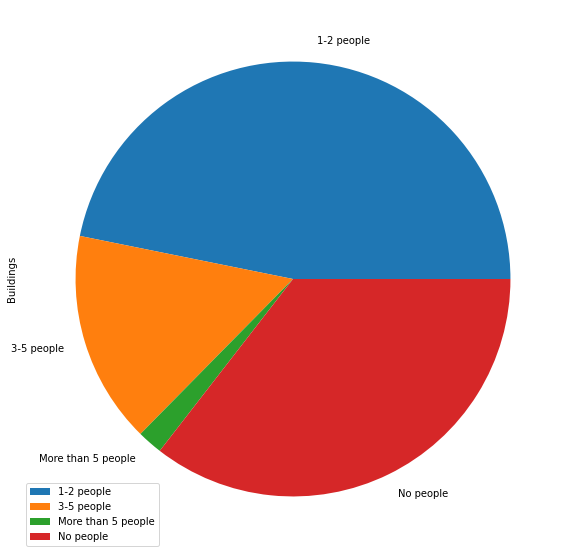

In [104]:
hua_gdf.groupby(['new_pop']).sum().plot(kind='pie', y='Buildings')

Text(0.5, 1.0, 'Number of people per household')

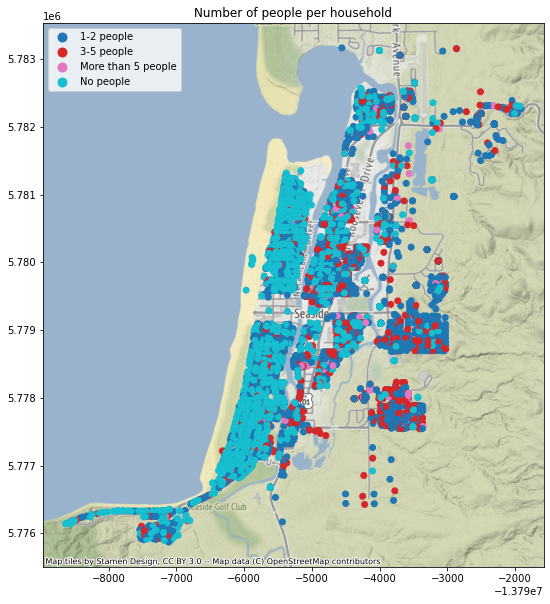

In [105]:
pop_map = viz.plot_gdf_map(hua_gdf,column='new_pop')
plt.title("Number of people per household")

Text(0.5, 1.0, 'Vaccancy')

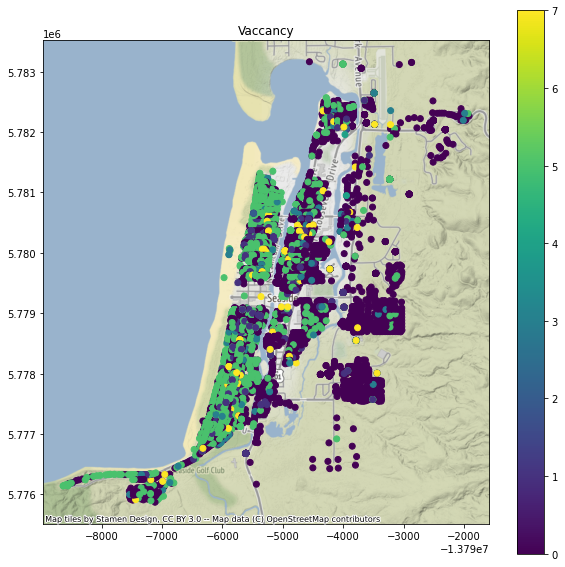

In [55]:
vacancy = viz.plot_gdf_map(hua_gdf,column='vacancy')
plt.title("Vaccancy")